In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ColabNotebooks/clasificaciondeImg/cubiertos

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ColabNotebooks/clasificaciondeImg/cubiertos


In [7]:
#Mostrar cuantas imagenes tengo de cada categoria
!ls ./cucharas | wc -l #475  #243
!ls ./cuchillos | wc -l #515  #169
!ls ./tenedores | wc -l #419  #190

243
169
190


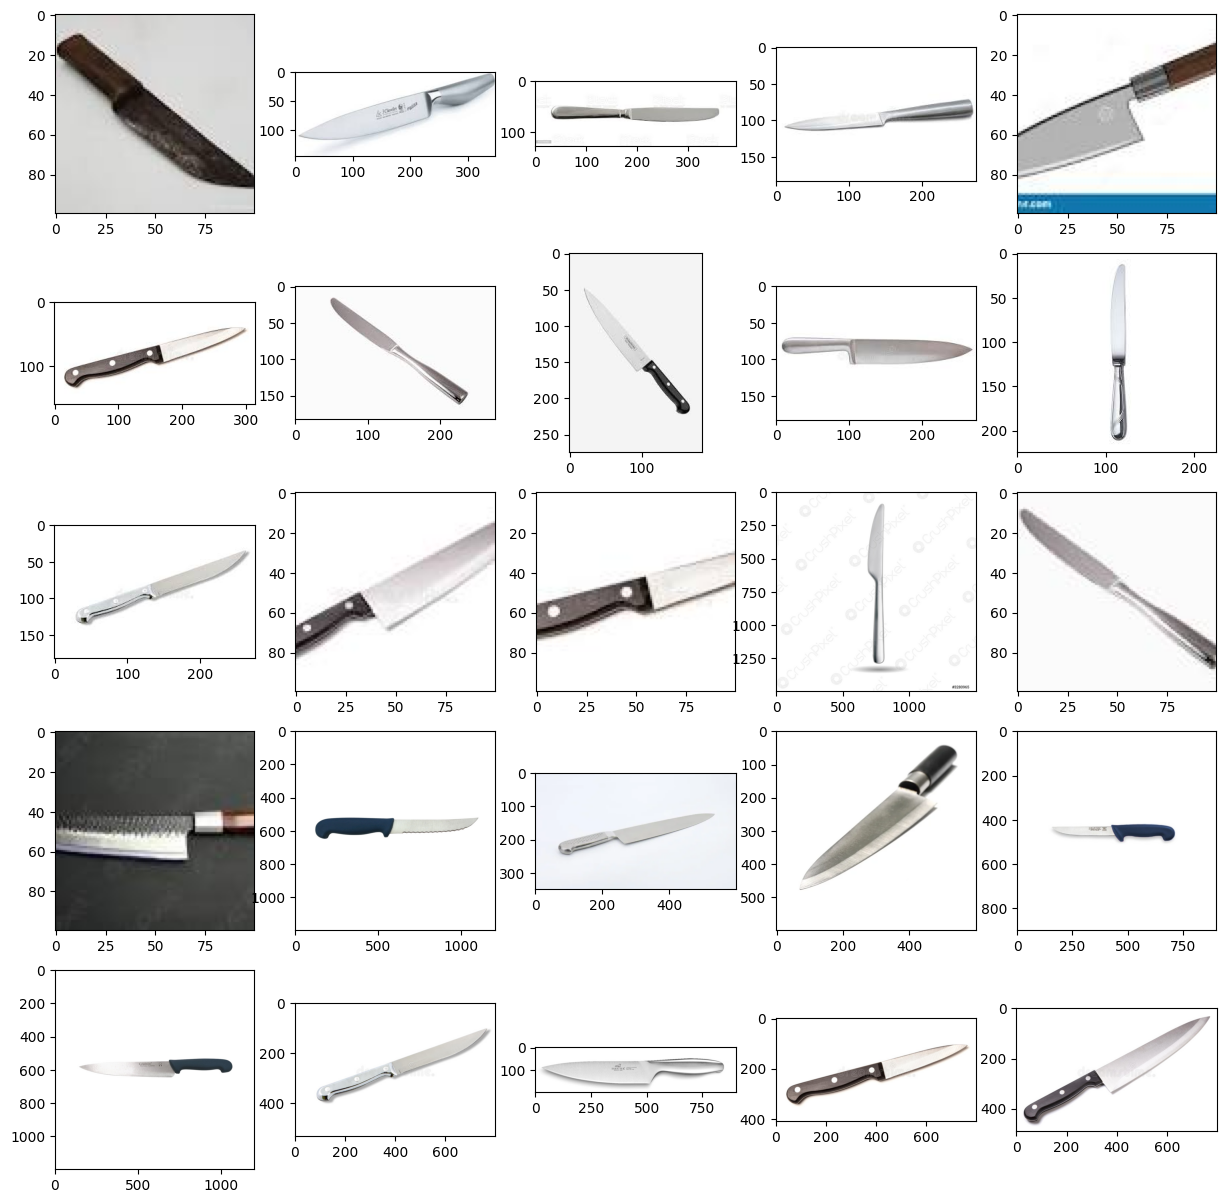

In [8]:
#Mostrar algunas imagenes con pyplot
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))

carpeta = './cuchillos'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:25]):
  plt.subplot(5,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg)
  plt.imshow(imagen)

In [9]:
#Crear carpetas para hacer el set de datos
!mkdir ./dataset
!mkdir ./dataset/cuchillo
!mkdir ./dataset/tenedor
!mkdir ./dataset/cuchara

In [12]:
#Copiar imagenes que subimos a carpetas del dataset
#Limitar para que todos tengan la misma cantidad de imagenes
#maximo 419 (el num. menor de imagenes que subi)

import shutil
carpeta_fuente = './cuchillos'
carpeta_destino = './dataset/cuchillo'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 169:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [14]:
carpeta_fuente = './tenedores'
carpeta_destino = './dataset/tenedor'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 169:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [15]:
carpeta_fuente = './cucharas'
carpeta_destino = './dataset/cuchara'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 169:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [16]:
#Mostrar cuantas imagenes tengo de cada categoria en el dataset
!ls ./dataset/cuchara | wc -l
!ls ./dataset/cuchillo | wc -l
!ls ./dataset/tenedor | wc -l

169
169
169


Found 403 images belonging to 3 classes.
Found 98 images belonging to 3 classes.


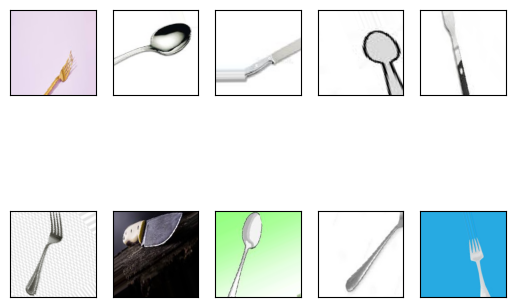

In [18]:
#Aumento de datos con ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

#Crear el dataset generador
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 15,
    zoom_range = [0.5, 1.5],
    validation_split=0.2 #20% para pruebas
)

#Generadores para sets de entrenamiento y pruebas
data_gen_entrenamiento = datagen.flow_from_directory('./dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='training')
data_gen_pruebas = datagen.flow_from_directory('./dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='validation')

#Imprimir 10 imagenes del generador de entrenamiento
for imagen, etiqueta in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break
plt.show()


In [19]:
import tensorflow as tf
import tensorflow_hub as hub

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))

In [20]:
#Congelar el modelo descargado
mobilenetv2.trainable = False

In [21]:
modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(3, activation='softmax')
])

In [22]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [23]:
#Compilar como siempre
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
#Entrenar el modelo
EPOCAS = 50

historial = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas
)

Epoch 1/50
13/13 [==============================] - 33s 2s/step - loss: 1.0117 - accuracy: 0.5012 - val_loss: 0.7082 - val_accuracy: 0.7653
Epoch 2/50
13/13 [==============================] - 32s 3s/step - loss: 0.6109 - accuracy: 0.7717 - val_loss: 0.4787 - val_accuracy: 0.8265
Epoch 3/50
13/13 [==============================] - 34s 3s/step - loss: 0.4728 - accuracy: 0.8213 - val_loss: 0.4802 - val_accuracy: 0.8163
Epoch 4/50
13/13 [==============================] - 33s 3s/step - loss: 0.3906 - accuracy: 0.8635 - val_loss: 0.3486 - val_accuracy: 0.8367
Epoch 5/50
13/13 [==============================] - 33s 3s/step - loss: 0.3378 - accuracy: 0.8734 - val_loss: 0.3536 - val_accuracy: 0.9082
Epoch 6/50
13/13 [==============================] - 32s 2s/step - loss: 0.3386 - accuracy: 0.8759 - val_loss: 0.4170 - val_accuracy: 0.8469
Epoch 7/50
13/13 [==============================] - 33s 3s/step - loss: 0.3472 - accuracy: 0.8586 - val_loss: 0.3342 - val_accuracy: 0.9082
Epoch 8/50
13/13 [==

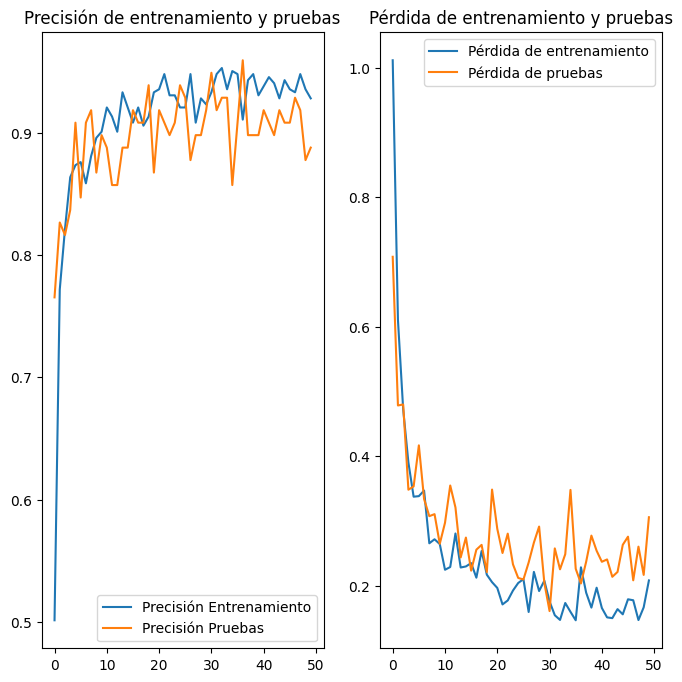

In [25]:
#Graficas de precisión
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(50)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [39]:
#Categorizar una imagen de internet
from PIL import Image
import requests
from io import BytesIO
import cv2
import numpy as np

def categorizar(img):
  ##respuesta = requests.get(url)
  ##img = Image.open(BytesIO(url))
  ##img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224,224))
  prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))
  return np.argmax(prediccion[0], axis=-1)

In [53]:
#This code is used if we have a img for testing
img = cv2.imread("./cuchara_tenedor_cuchillo.jpg")
img = cv2.resize(img, (224,224))

In [54]:
#0 = cuchara, 1 = cuchillo, 2 = tenedor
prediccion = categorizar (img)
print(prediccion)

1/1 [==============================] - 0s 58ms/step
1


In [45]:
#Crear la carpeta para exportarla a TF Serving
!mkdir -p ./carpeta_salida/modelo_cocina/1

In [46]:
#Guardar el modelo en formato SavedModel
modelo.save('./carpeta_salida/modelo_cocina/1')

In [48]:
#Hacerlo un zip para bajarlo y usarlo en otro lado
!zip -r modelo_cocina.zip ./carpeta_salida/modelo_cocina/

  adding: carpeta_salida/modelo_cocina/ (stored 0%)
  adding: carpeta_salida/modelo_cocina/1/ (stored 0%)
  adding: carpeta_salida/modelo_cocina/1/variables/ (stored 0%)
  adding: carpeta_salida/modelo_cocina/1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: carpeta_salida/modelo_cocina/1/variables/variables.index (deflated 78%)
  adding: carpeta_salida/modelo_cocina/1/assets/ (stored 0%)
  adding: carpeta_salida/modelo_cocina/1/saved_model.pb (deflated 91%)
  adding: carpeta_salida/modelo_cocina/1/fingerprint.pb (stored 0%)
  adding: carpeta_salida/modelo_cocina/1/keras_metadata.pb (deflated 80%)


In [49]:
converter = tf.lite.TFLiteConverter.from_keras_model(modelo)


In [50]:
tflite_model=converter.convert()

In [51]:
open("./mask_classifier.tflite","wb").write(tflite_model)

8880404